# Audio Deepfake Detection -- Final Report

This notebook consolidates all experimental results for the audio deepfake detection project. It covers training data exploration, feature selection, per-model grid search details with evaluations on three datasets (FoR test, In-the-Wild, ElevenLabs), zero-shot generalization analysis, and conclusions.

---
## 0. Setup and Imports

In [4]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath(os.getcwd()))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from configs.config import (
    FEATURES_DIR, ITW_DATASET_PATH, ELEVEN_LABS_FEATURES_PATH, FINAL_MODELS_PATH
)
from utils.utils import evaluate_model_on_parquet, plot_roc_curve

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

print(f"Project root: {PROJECT_ROOT}")
print(f"Features dir: {FEATURES_DIR}")
print(f"Final models: {FINAL_MODELS_PATH}")

Project root: c:\Users\geon9\MSc\audio-deepfake-detection
Features dir: c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features
Final models: c:\Users\geon9\MSc\audio-deepfake-detection\notebooks\experiments\final


In [5]:
# ── Dataset paths ──
TRAIN_PATH = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
FOR_TEST_PATH = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")
ITW_PATH = os.path.join(ITW_DATASET_PATH, "normalized_features",
                        "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")
ELEVEN_PATH = os.path.join(ELEVEN_LABS_FEATURES_PATH,
                           "eleven_labs_features_mean_20_128_256_128.parquet")

# No-mel variants (for XGB_NO_MEL)
FOR_TEST_NO_MEL = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128_no_mel.parquet")
ITW_NO_MEL = os.path.join(ITW_DATASET_PATH, "normalized_features",
                          "itw_features_mean_20_128_256_128_no_mel_trimmed_loudness_normalized.parquet")
ELEVEN_NO_MEL = os.path.join(ELEVEN_LABS_FEATURES_PATH,
                             "eleven_labs_features_mean_20_128_256_128_no_mel.parquet")

# Verify paths exist
for name, p in [("Train", TRAIN_PATH), ("FoR Test", FOR_TEST_PATH),
                ("ITW", ITW_PATH), ("ElevenLabs", ELEVEN_PATH)]:
    print(f"{name}: {'OK' if os.path.exists(p) else 'MISSING'} -- {p}")

Train: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\training_features_mean_20_128_256_128.parquet
FoR Test: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\testing_features_mean_20_128_256_128.parquet
ITW: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\in-the-wild-audio-deepfake\normalized_features\itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet
ElevenLabs: OK -- c:\Users\geon9\MSc\audio-deepfake-detection\elevenlabs-dataset\features\eleven_labs_features_mean_20_128_256_128.parquet


In [6]:
# ── Model registry ──
# Maps display name -> (experiment subdir, uses_no_mel_features)
MODEL_REGISTRY = {
    "Logistic Regression": ("logistic_reg/exp_20260207_192945", False),
    "Linear SVM":          ("linear_svm/exp_20260207_193304", False),
    "RBF SVM":             ("rbf_svm/exp_20260207_200752", False),
    "Polynomial SVM":      ("poly_svm/exp_20260207_201742", False),
    "Sigmoid SVM":         ("sigmoid_svm/exp_20260207_204305", False),
    "Decision Tree":       ("Dtree/exp_20260207_210558", False),
    "Random Forest":       ("RF/exp_20260208_163746", False),
    "XGBoost":             ("XGB/exp_20260208_160623", False),
    "XGBoost (no mel)":    ("XGB_NO_MEL/exp_20260208_034900", True),
}

# Grid search spaces used for each model
GRID_SEARCH_SPACES = {
    "Logistic Regression": {
        "C": "np.logspace(-3, 2, 10)  [0.001 ... 100]",
        "penalty": ["l1", "l2"],
        "solver": ["saga"],
    },
    "Linear SVM": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    "RBF SVM": {
        "kernel": ["rbf"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", 0.01, 0.1],
    },
    "Polynomial SVM": {
        "kernel": ["poly"],
        "degree": [2, 3],
        "C": [0.1, 1, 10],
        "gamma": ["scale", 0.01],
        "coef0": [0.0, 1.0],
    },
    "Sigmoid SVM": {
        "kernel": ["sigmoid"],
        "C": [0.01, 0.1, 1],
        "gamma": ["scale", 0.01],
        "coef0": [-1.0, 0.0, 1.0],
    },
    "Decision Tree": {
        "max_depth": "range(5, 20)",
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["{0:1, 1:5}", None],
        "criterion": ["gini", "entropy"],
        "ccp_alpha": [0.0, 1e-4, 1e-3, 1e-2],
    },
    "Random Forest": {
        "n_estimators": [300, 500, 700, 800],
        "max_depth": [2, 3, 4, 5],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [5, 10, 20],
        "min_samples_leaf": [2, 5, 10],
        "max_samples": [0.5, 0.6, 0.7],
        "class_weight": ["{0:1, 1:5}", None],
    },
    "XGBoost": {
        "max_depth": [3, 4, 2],
        "learning_rate": [0.03, 0.05],
        "n_estimators": [700, 800],
        "min_child_weight": [10, 20],
        "gamma": [0.3],
        "reg_lambda": [2, 1],
        "reg_alpha": [0.5],
        "subsample": [0.6, 0.7, 0.5],
        "colsample_bytree": [0.6, 0.7],
        "scale_pos_weight": [2],
    },
    "XGBoost (no mel)": {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.03, 0.05],
        "n_estimators": [300, 500, 700],
        "min_child_weight": [5, 10, 20],
        "gamma": [0.1, 0.3, 0.5],
        "reg_lambda": [2, 5, 10],
        "reg_alpha": [0, 0.5, 1],
        "subsample": [0.6, 0.7, 0.8],
        "colsample_bytree": [0.6, 0.7, 0.8],
        "scale_pos_weight": [1, 2, 3],
    },
}

print(f"Models registered: {len(MODEL_REGISTRY)}")

Models registered: 9


In [7]:
# ── Helper functions ──

def load_experiment(model_name):
    """Load model, metrics, params, and metadata for a registered model."""
    subdir, _ = MODEL_REGISTRY[model_name]
    exp_dir = os.path.join(FINAL_MODELS_PATH, subdir)
    model = joblib.load(os.path.join(exp_dir, "model.joblib"))
    with open(os.path.join(exp_dir, "metrics.json")) as f:
        metrics = json.load(f)
    with open(os.path.join(exp_dir, "model_params.json")) as f:
        params = json.load(f)
    with open(os.path.join(exp_dir, "metadata.json")) as f:
        metadata = json.load(f)
    return model, metrics, params, metadata


def load_test_data(path):
    """Load a parquet test dataset and return X, y arrays."""
    df = pd.read_parquet(path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    X = df.drop(columns=["label", "filename"], errors="ignore").values
    y = df["label"].map({"real": 0, "fake": 1}).values
    return X, y


def evaluate_on_dataset(model, X, y):
    """Compute metrics dict for a model on (X, y)."""
    y_pred = model.predict(X)
    metrics = {
        "Accuracy":  accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average="macro"),
        "Recall":    recall_score(y, y_pred, average="macro"),
        "F1 (macro)": f1_score(y, y_pred, average="macro"),
    }
    if hasattr(model, "predict_proba"):
        metrics["ROC AUC"] = roc_auc_score(y, model.predict_proba(X)[:, 1])
    elif hasattr(model, "decision_function"):
        metrics["ROC AUC"] = roc_auc_score(y, model.decision_function(X))
    return metrics, y_pred


def plot_confusion_matrices(model, datasets, titles, suptitle=""):
    """Plot side-by-side confusion matrices for multiple datasets."""
    n = len(datasets)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, (X, y), title in zip(axes, datasets, titles):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
        disp.plot(ax=ax, colorbar=False)
        ax.set_title(title)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_roc_curves_overlay(model, datasets, labels, title="ROC Curves"):
    """Plot ROC curves for one model on multiple datasets, overlaid."""
    fig, ax = plt.subplots(figsize=(6, 5))
    for (X, y), label in zip(datasets, labels):
        plot_roc_curve(model, X, y, label=label, ax=ax)
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


print("Helpers loaded.")

Helpers loaded.


---
## 1. Training Data Visualization

We inspect the FoR training feature set to understand class distributions and feature correlations.

In [8]:
# Load training data
train_df = pd.read_parquet(TRAIN_PATH)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

# Encode labels
train_df["label_num"] = train_df["label"].map({"real": 0, "fake": 1})

feature_cols = [c for c in train_df.columns if c not in ["label", "filename", "label_num"]]

print(f"Training samples: {len(train_df)}")
print(f"  Real: {(train_df['label_num'] == 0).sum()}")
print(f"  Fake: {(train_df['label_num'] == 1).sum()}")
print(f"Features: {len(feature_cols)}")

Training samples: 53864
  Real: 26938
  Fake: 26926
Features: 195


### 1.1 Feature Histograms (Real vs Fake)

For each feature group we plot the overlapping distributions of real and fake samples.

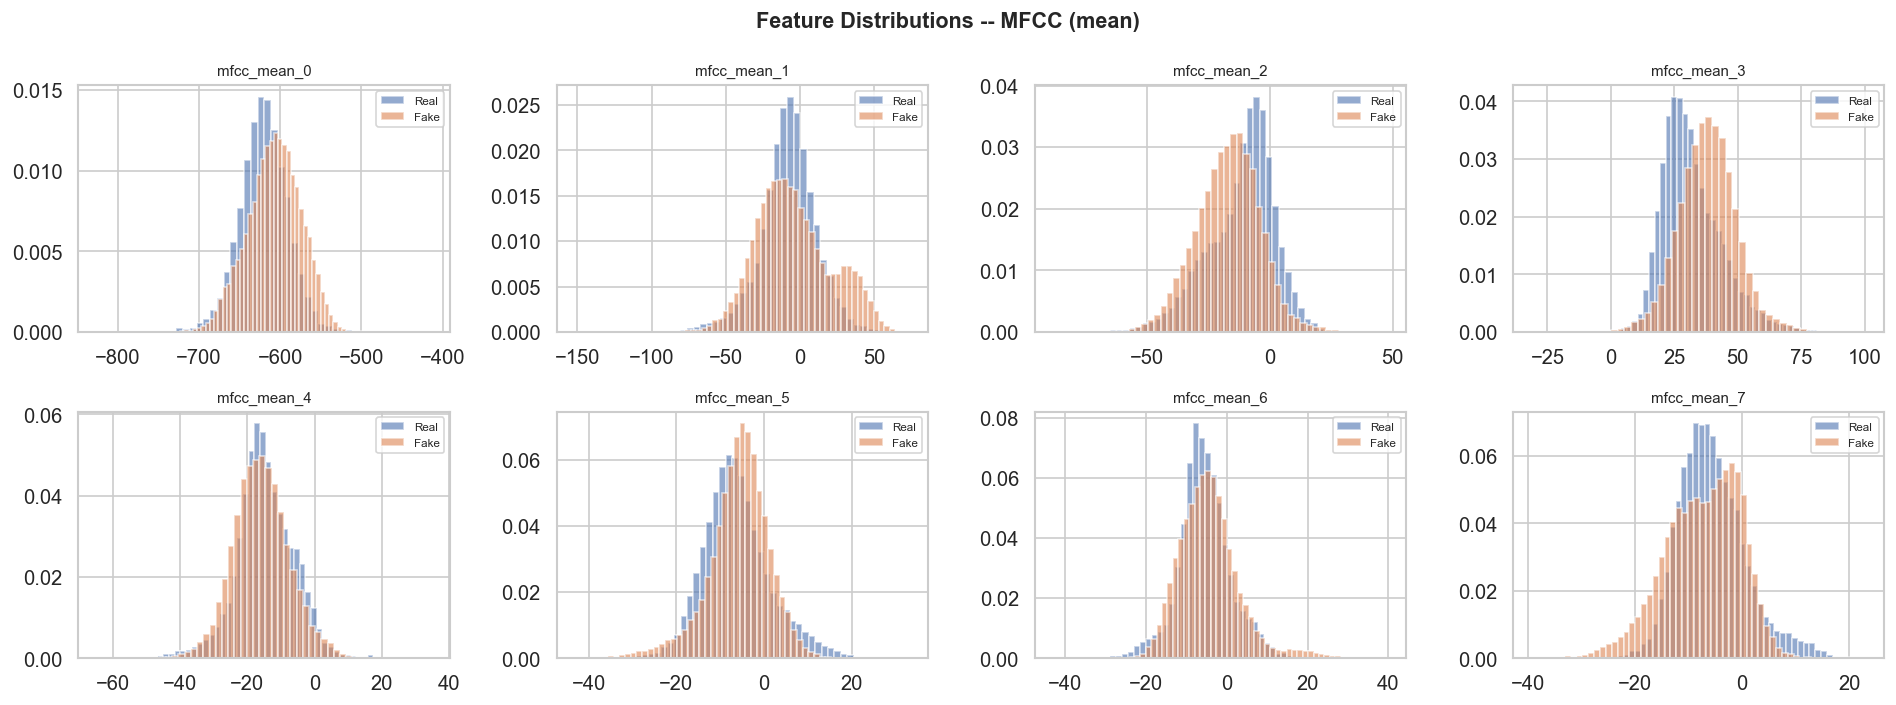

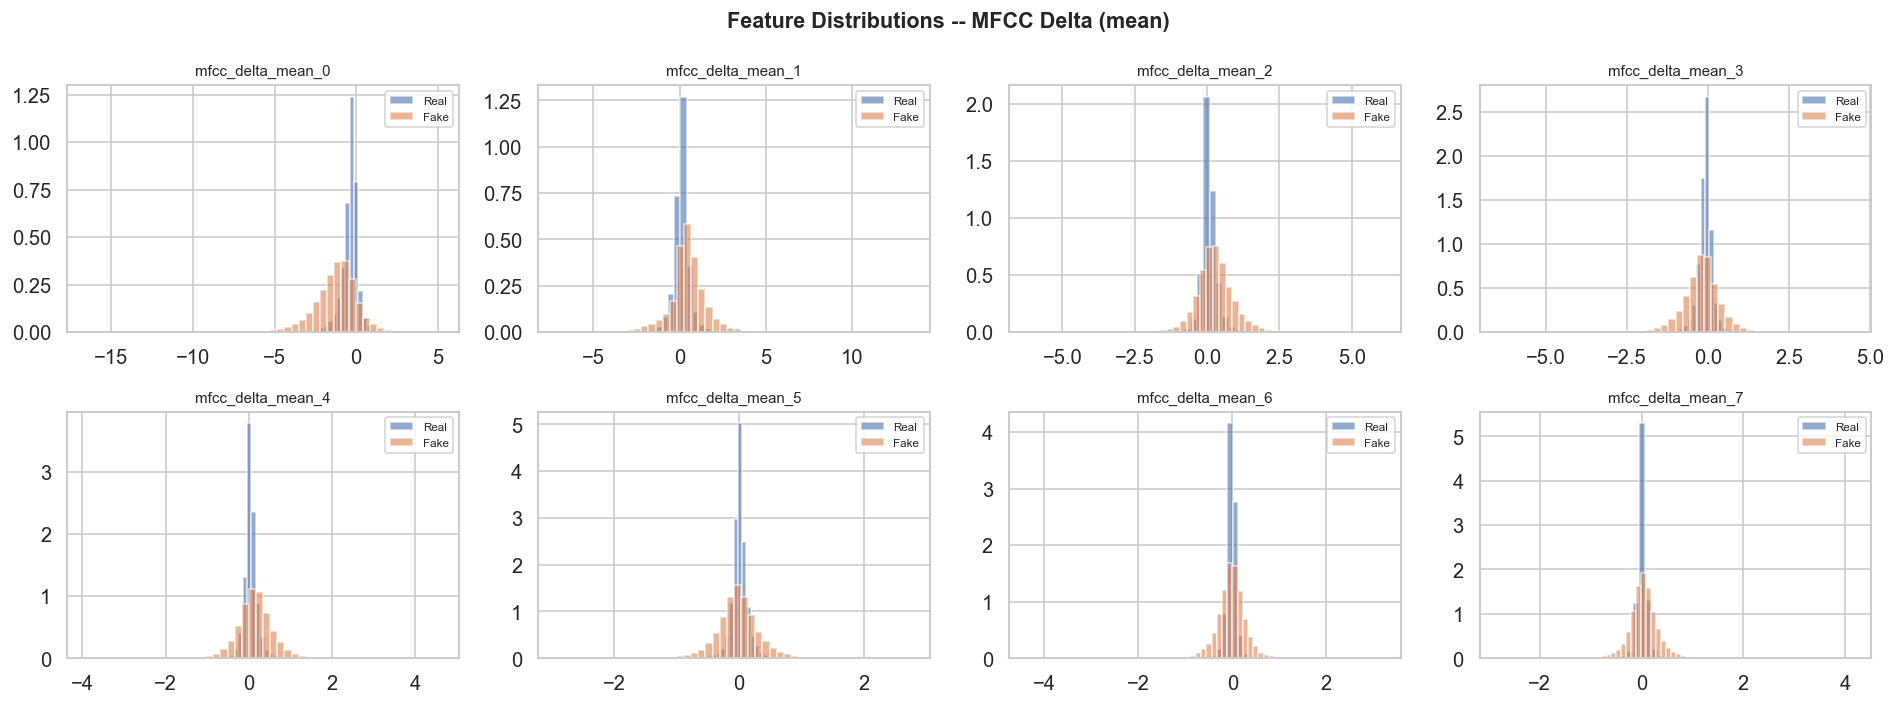

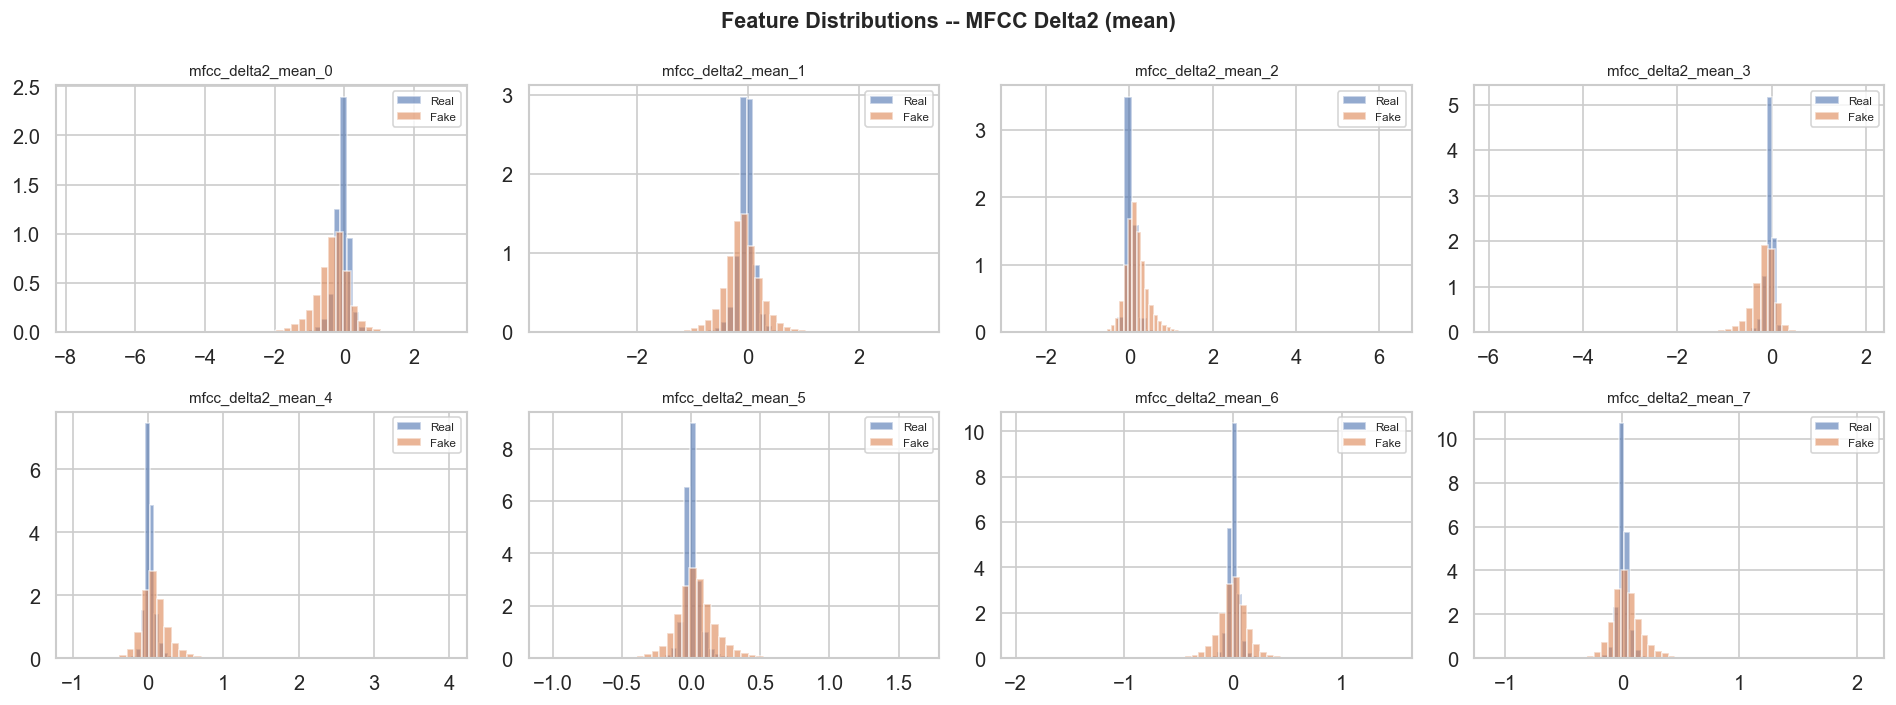

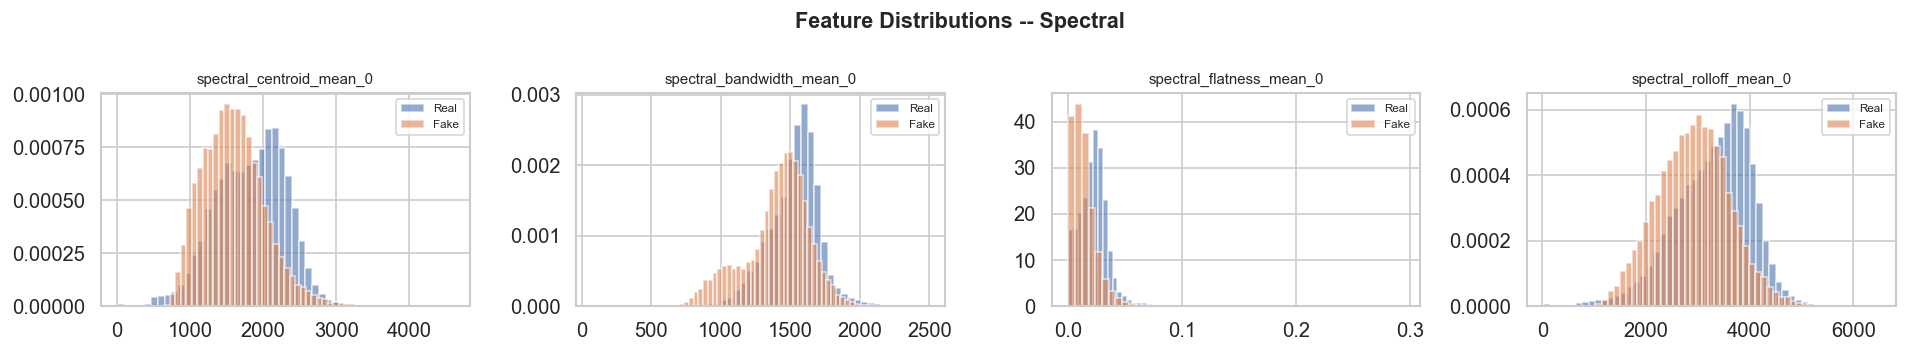

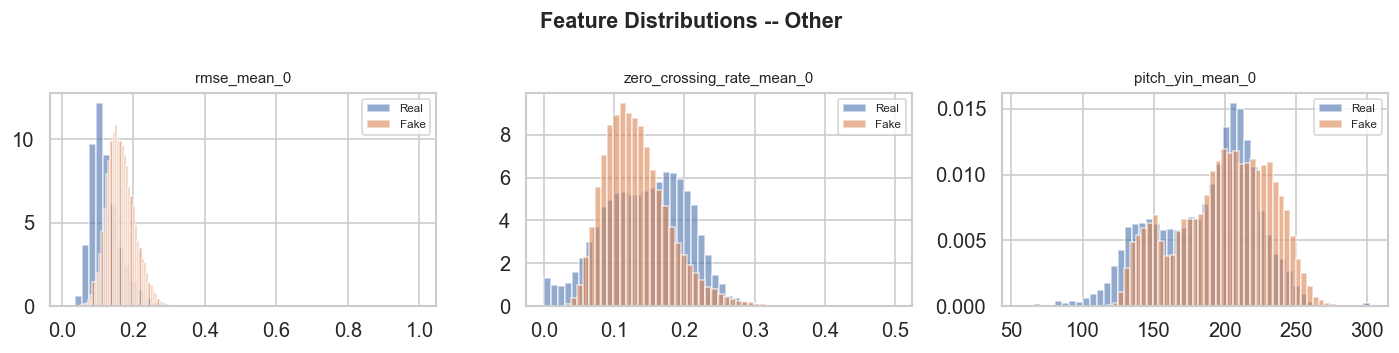

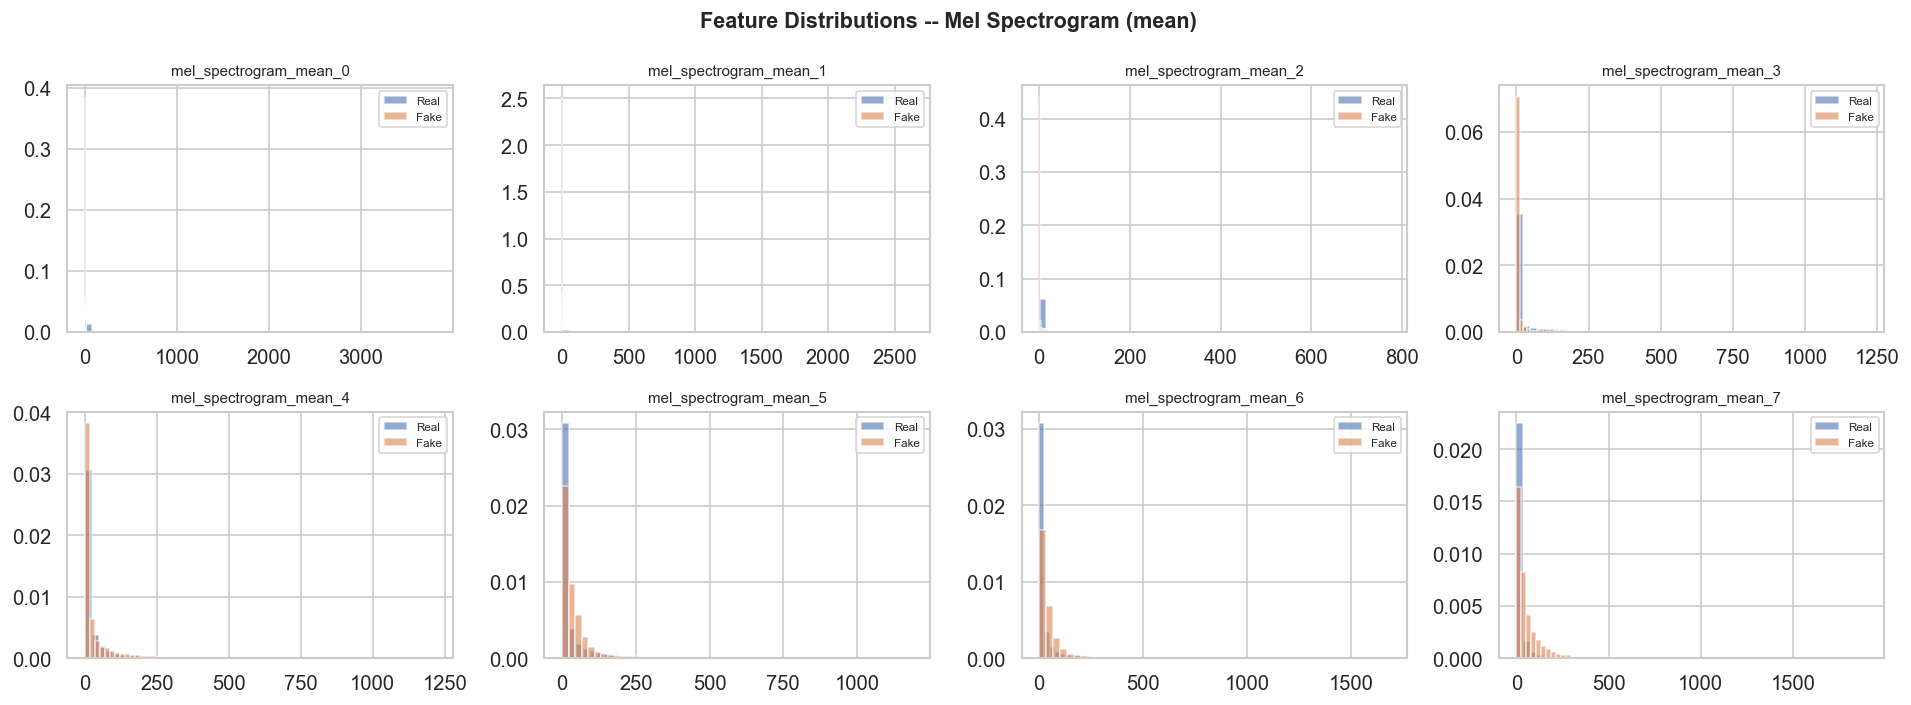

In [9]:
# Define feature groups with representative features
feature_groups = {
    "MFCC (mean)": [c for c in feature_cols if c.startswith("mfcc_mean_")],
    "MFCC Delta (mean)": [c for c in feature_cols if c.startswith("mfcc_delta_mean_")],
    "MFCC Delta2 (mean)": [c for c in feature_cols if c.startswith("mfcc_delta2_mean_")],
    "Spectral": [c for c in feature_cols if c.startswith("spectral_")],
    "Other": [c for c in feature_cols if c.startswith(("rmse_", "zero_crossing", "pitch_"))],
    "Mel Spectrogram (mean)": [c for c in feature_cols if c.startswith("mel_spectrogram_mean_")],
}

real_df = train_df[train_df["label_num"] == 0]
fake_df = train_df[train_df["label_num"] == 1]

for group_name, cols in feature_groups.items():
    # Show up to 8 representative features per group
    display_cols = cols[:8] if len(cols) > 8 else cols
    n = len(display_cols)
    ncols = min(4, n)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(display_cols):
        axes[i].hist(real_df[col], bins=50, alpha=0.6, label="Real", density=True)
        axes[i].hist(fake_df[col], bins=50, alpha=0.6, label="Fake", density=True)
        axes[i].set_title(col, fontsize=9)
        axes[i].legend(fontsize=7)

    # Hide unused axes
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f"Feature Distributions -- {group_name}", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

### 1.2 Correlation Heatmaps

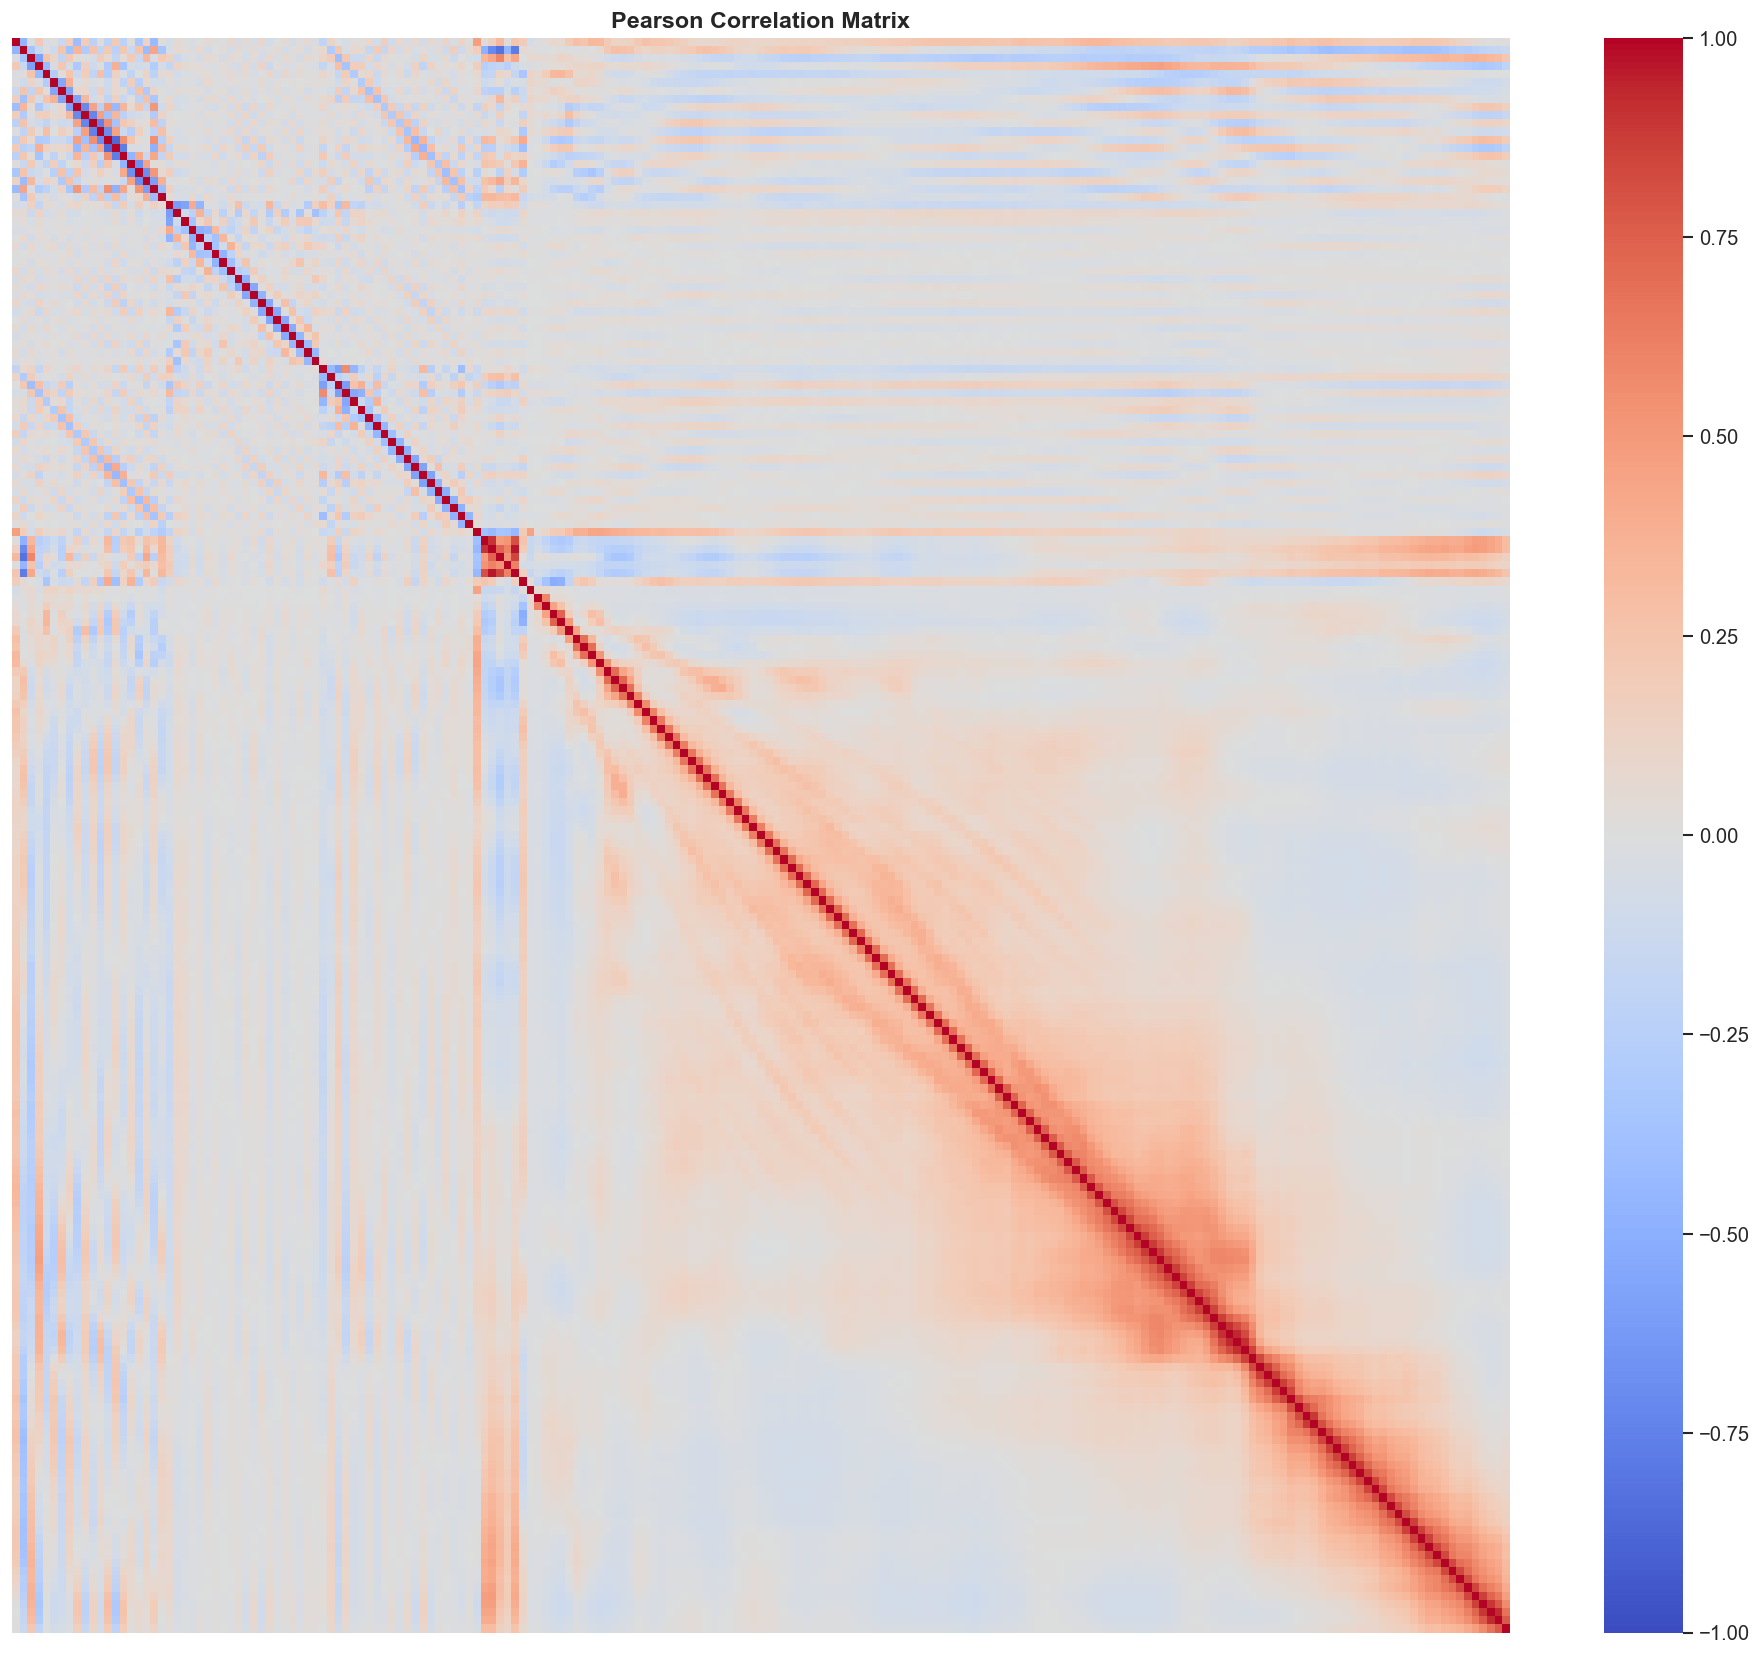

In [7]:
# Pearson correlation
corr_pearson = train_df[feature_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_pearson, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_title("Pearson Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

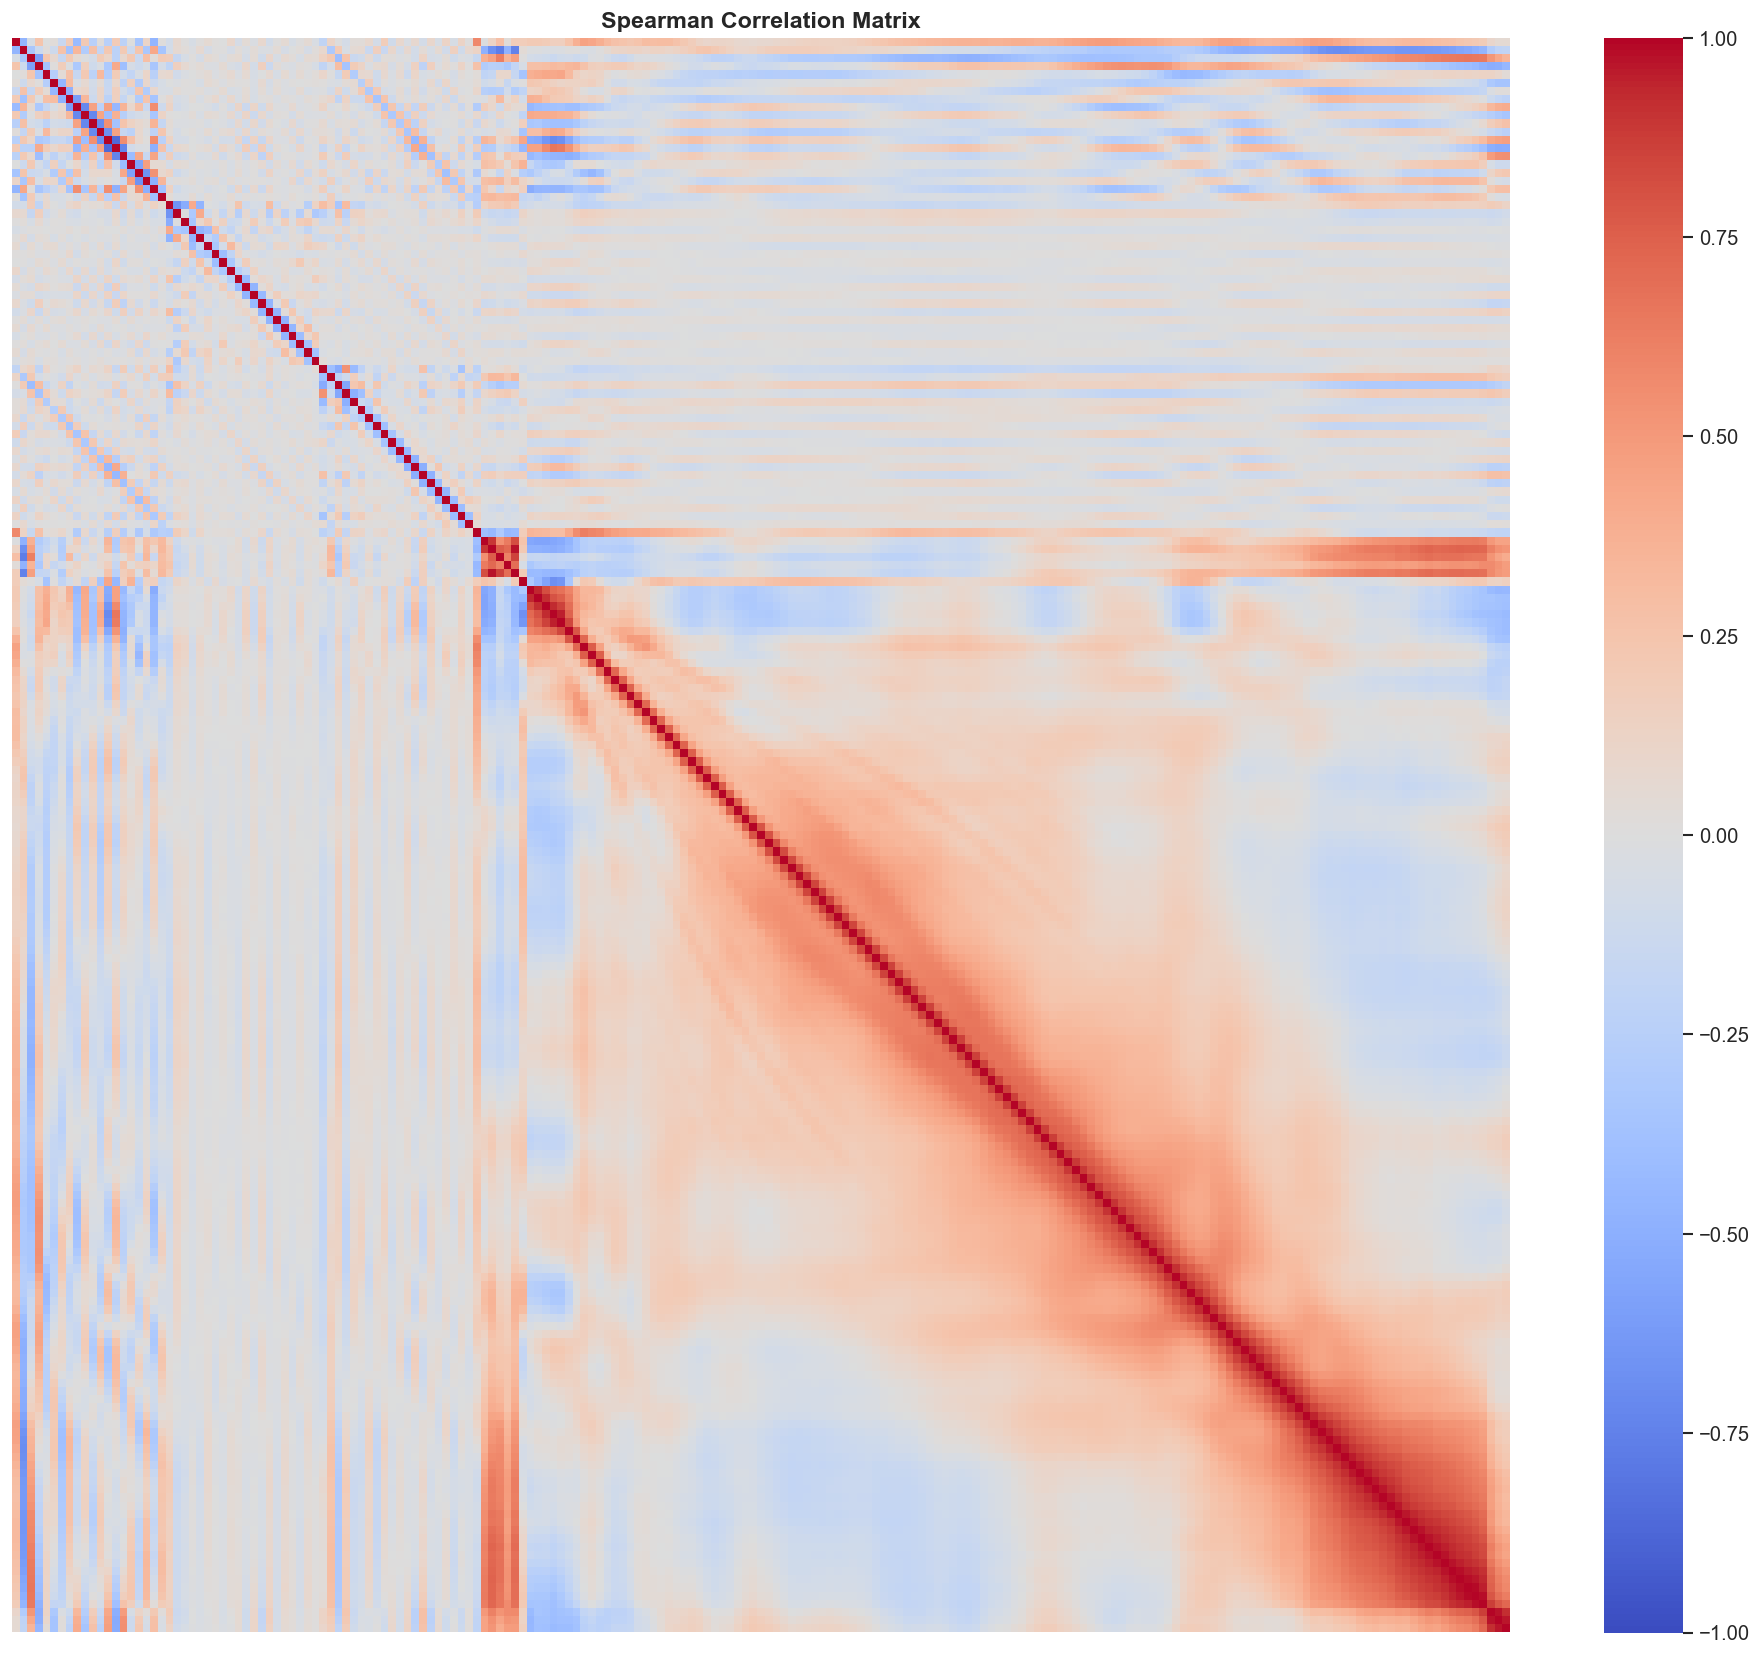

In [8]:
# Spearman correlation
corr_spearman = train_df[feature_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_spearman, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_title("Spearman Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 2. Feature Selection

Our feature set was selected empirically by training a logistic regression model on different feature subsets and comparing prediction scores. We started with the full extracted feature set and progressively tested variants to identify which combination yielded the best performance.

The extracted audio features fall into the following groups:
- **MFCC** (20 coefficients) -- mean and standard deviation per coefficient
- **MFCC Delta** (20 coefficients) -- first-order temporal derivatives
- **MFCC Delta2** (20 coefficients) -- second-order temporal derivatives
- **Mel Spectrogram** (128 bands) -- mean and standard deviation per band
- **Spectral features** -- centroid, bandwidth, flatness, rolloff
- **Other** -- RMSE, zero-crossing rate, pitch (YIN)

Each feature was computed as both a **mean** and a **standard deviation** across all frames of the audio clip.

In [10]:
# ── Feature subset comparison using Logistic Regression ──
# We trained the same Logistic Regression model on different feature subsets
# and compared prediction scores on the FoR validation set to decide which
# features to keep.

feature_variants = {
    "All features (mean + std)": {
        "Num. Features": "~394",
        "Description": "All extracted features including both mean and std aggregations",
        "Accuracy": 0.7225,
        "F1 (macro)": 0.7219,
        "ROC AUC": 0.7991,
    },
    "Without mel spectrogram": {
        "Num. Features": "~138",
        "Description": "Removed all 128 mel spectrogram bands (mean + std)",
        "Accuracy": 0.5490,
        "F1 (macro)": 0.5455,
        "ROC AUC": 0.5641,
    },
    "Mean only (selected)": {
        "Num. Features": "195",
        "Description": "Kept only mean aggregations, dropped all std features",
        "Accuracy": 0.7758,
        "F1 (macro)": 0.7751,
        "ROC AUC": 0.8543,
    },
}

variant_df = pd.DataFrame(feature_variants).T
variant_df.index.name = "Feature Set"

display(variant_df.style.format(
    {"Accuracy": "{:.4f}", "F1 (macro)": "{:.4f}", "ROC AUC": "{:.4f}"},
    subset=["Accuracy", "F1 (macro)", "ROC AUC"]
).background_gradient(
    cmap="RdYlGn", subset=["Accuracy", "F1 (macro)", "ROC AUC"], axis=0
))

,Num. Features,Description,Accuracy,F1 (macro),ROC AUC
Feature Set,,,,,
All features (mean + std),~394,All extracted features including both mean and std aggregations,0.7225,0.7219,0.7991
Without mel spectrogram,~138,Removed all 128 mel spectrogram bands (mean + std),0.5490,0.5455,0.5641
Mean only (selected),195,"Kept only mean aggregations, dropped all std features",0.7758,0.7751,0.8543


### How we chose the final feature set

We started with the full set of extracted audio features (~394 in total), which included both the **mean** and **standard deviation** of every feature computed across all frames of each audio clip.

We then trained a simple Logistic Regression classifier on three variants of the feature set and compared prediction scores:

1. **All features (mean + std, ~394)** -- Decent baseline (F1 = 0.72), but the standard-deviation features added noise rather than signal.
2. **Without mel spectrogram (~138)** -- Performance collapsed (F1 = 0.55), confirming that mel spectrogram bands carry critical information for distinguishing real from fake audio.
3. **Mean only, no std (195)** -- Best results (F1 = 0.78, ROC AUC = 0.85). Dropping the standard deviation aggregations removed noisy, redundant information and improved every metric.

Based on these results, we selected the **mean-only feature set (195 features)** for all subsequent model training. This set includes 20 MFCC means, 20 delta means, 20 delta2 means, 128 mel spectrogram band means, and 7 additional features (RMSE, ZCR, spectral centroid/bandwidth/flatness/rolloff, pitch).

---
## 3. Per-Model Results

For each of the 9 final models we show:
1. Grid search parameter space
2. Best hyperparameters selected
3. Metrics on FoR test set, In-the-Wild (ITW), and ElevenLabs
4. Confusion matrices on all three datasets
5. ROC AUC curves on all three datasets

In [12]:
# Pre-load all test datasets
print("Loading test datasets...")
X_for, y_for = load_test_data(FOR_TEST_PATH)
X_itw, y_itw = load_test_data(ITW_PATH)
X_eleven, y_eleven = load_test_data(ELEVEN_PATH)

# No-mel variants
if os.path.exists(FOR_TEST_NO_MEL):
    X_for_nm, y_for_nm = load_test_data(FOR_TEST_NO_MEL)
else:
    X_for_nm, y_for_nm = None, None

if os.path.exists(ITW_NO_MEL):
    X_itw_nm, y_itw_nm = load_test_data(ITW_NO_MEL)
else:
    X_itw_nm, y_itw_nm = None, None

if os.path.exists(ELEVEN_NO_MEL):
    X_eleven_nm, y_eleven_nm = load_test_data(ELEVEN_NO_MEL)
else:
    X_eleven_nm, y_eleven_nm = None, None

print(f"FoR test:    {X_for.shape}")
print(f"ITW:         {X_itw.shape}")
print(f"ElevenLabs:  {X_eleven.shape}")
if X_for_nm is not None:
    print(f"FoR (no mel): {X_for_nm.shape}")
if X_itw_nm is not None:
    print(f"ITW (no mel): {X_itw_nm.shape}")
if X_eleven_nm is not None:
    print(f"ElevenLabs (no mel): {X_eleven_nm.shape}")

Loading test datasets...
FoR test:    (4634, 195)
ITW:         (31526, 195)
ElevenLabs:  (136, 195)
FoR (no mel): (4634, 67)
ITW (no mel): (31526, 67)
ElevenLabs (no mel): (136, 67)


In [13]:
# ── Collect all results for later summary ──
all_results = {}  # model_name -> {"FoR": metrics, "ITW": metrics, "ElevenLabs": metrics}
all_predictions = {}  # for confusion matrices in Section 4

### 3.1 Logistic Regression

In [14]:
name = "Logistic Regression"
model, saved_metrics, params, metadata = load_experiment(name)

# Grid search space
print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

# Evaluate on all datasets
datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  C: np.logspace(-3, 2, 10)  [0.001 ... 100]
  penalty: ['l1', 'l2']
  solver: ['saga']

Best Parameters: {
  "clf__C": 2.1544346900318843,
  "clf__max_iter": 1000,
  "clf__penalty": "l2",
  "clf__solver": "saga"
}


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.8571,0.8868,0.8540,0.8535,0.9819
ITW,0.7163,0.7060,0.7179,0.7073,0.7775
ElevenLabs,0.6029,0.7070,0.5671,0.4988,0.6541


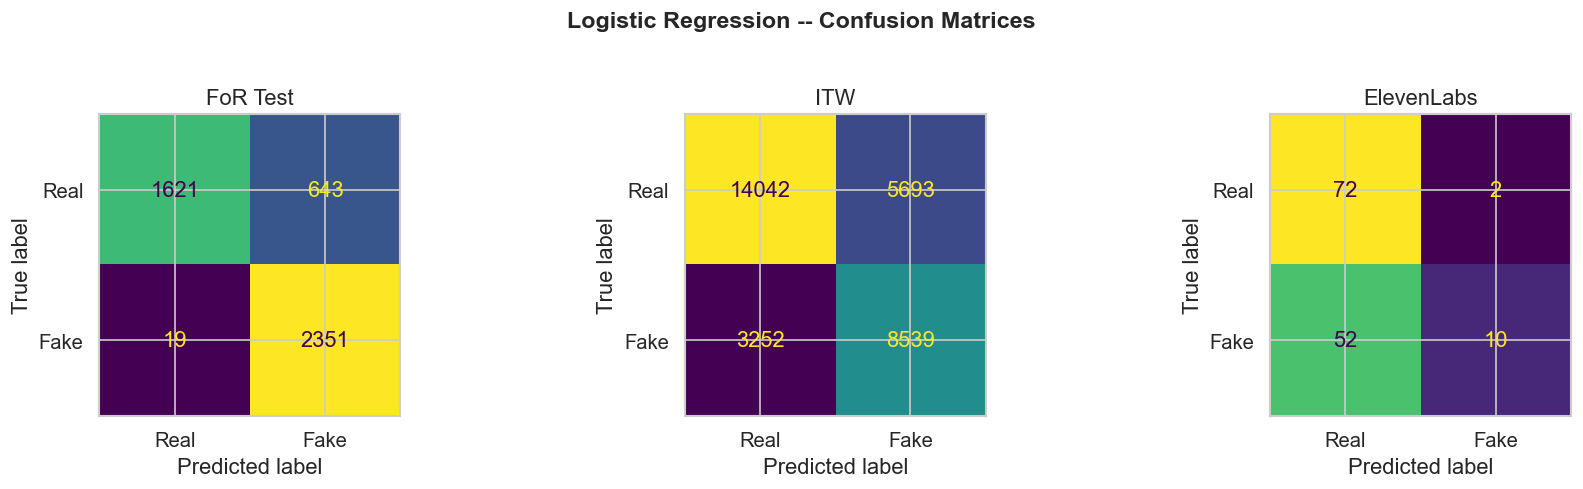

In [15]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Logistic Regression -- Confusion Matrices")

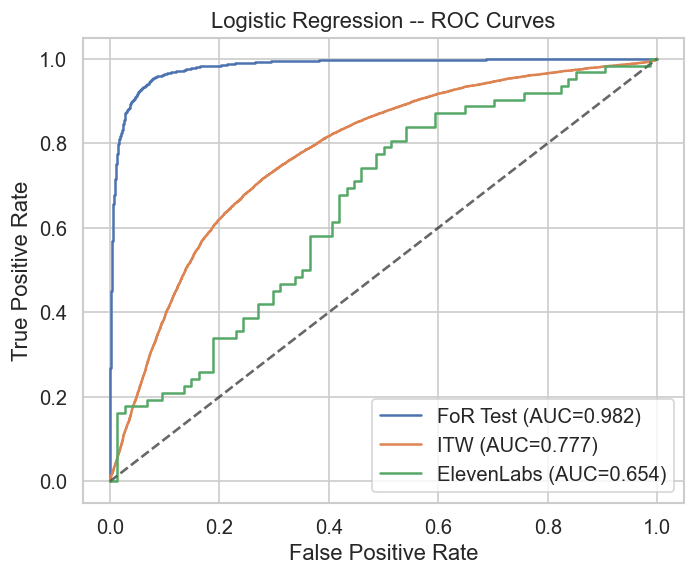

In [16]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Logistic Regression -- ROC Curves")

### 3.2 Linear SVM

In [17]:
name = "Linear SVM"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  C: [0.001, 0.01, 0.1, 1, 10, 100, 1000]

Best Parameters: {
  "svm__C": 0.01
}


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.8435,0.8789,0.8401,0.8388,0.9816
ITW,0.7200,0.7075,0.7181,0.7097,0.7811
ElevenLabs,0.6103,0.7158,0.5752,0.5121,0.6707


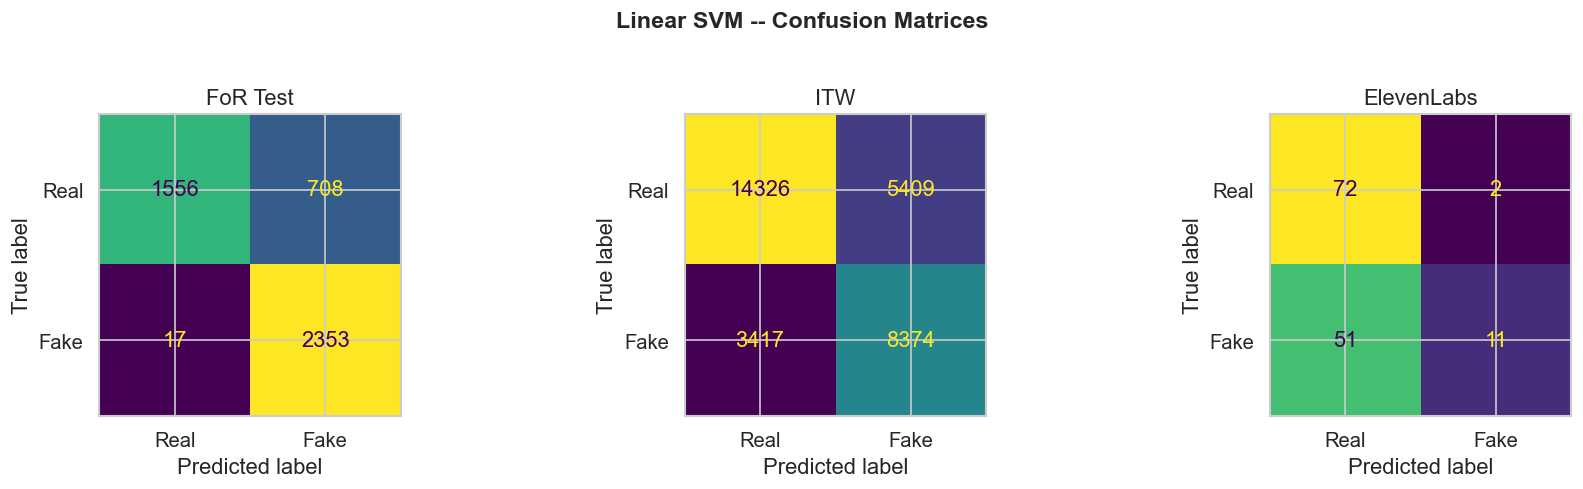

In [18]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Linear SVM -- Confusion Matrices")

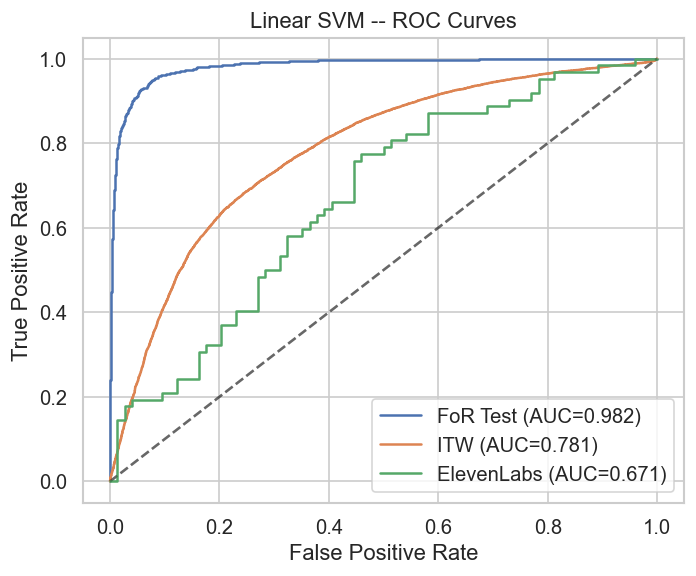

In [19]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Linear SVM -- ROC Curves")

### 3.3 RBF SVM

In [20]:
name = "RBF SVM"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  kernel: ['rbf']
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 0.01, 0.1]

Best Parameters: {
  "svm__C": 0.1,
  "svm__gamma": 0.01,
  "svm__kernel": "rbf"
}


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.9566,0.9609,0.9556,0.9564,0.9999
ITW,0.7059,0.6968,0.7086,0.6974,0.7631
ElevenLabs,0.5735,0.6974,0.5336,0.4314,0.7273


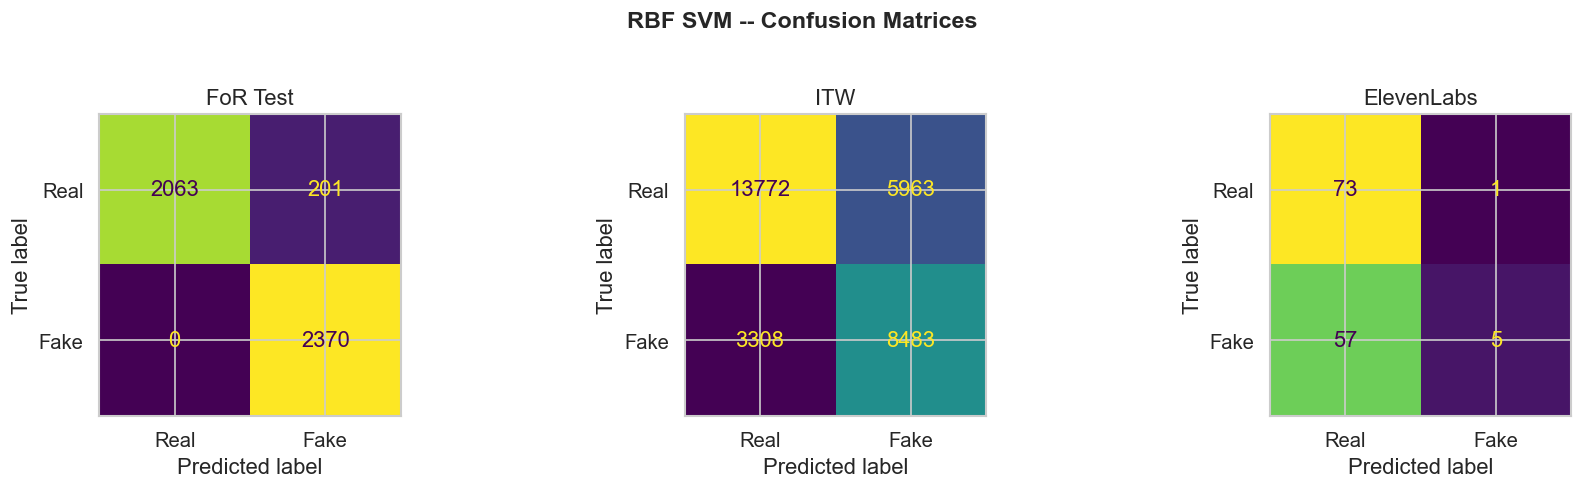

In [21]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="RBF SVM -- Confusion Matrices")

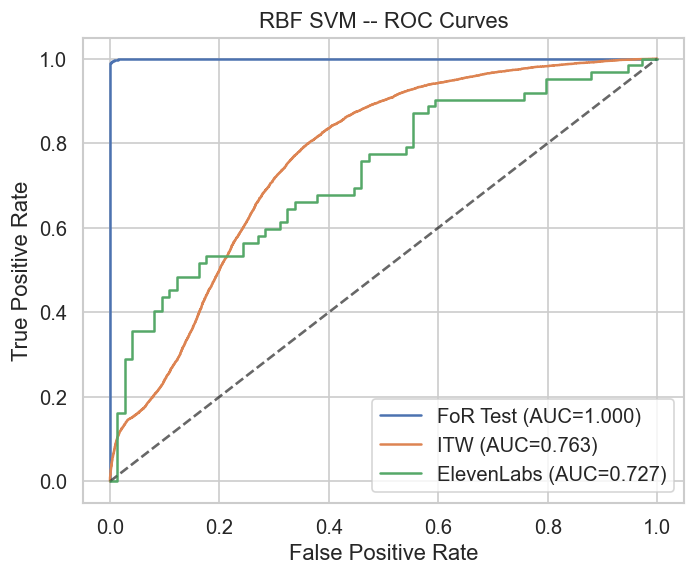

In [22]:
plot_roc_curves_overlay(model, datasets, ds_names, title="RBF SVM -- ROC Curves")

### 3.4 Polynomial SVM

In [23]:
name = "Polynomial SVM"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  kernel: ['poly']
  degree: [2, 3]
  C: [0.1, 1, 10]
  gamma: ['scale', 0.01]
  coef0: [0.0, 1.0]

Best Parameters: {
  "svm__C": 1,
  "svm__coef0": 0.0,
  "svm__degree": 2,
  "svm__gamma": 0.01,
  "svm__kernel": "poly"
}


c:\Users\geon9\MSc\audio-deepfake-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.9978,0.9979,0.9978,0.9978,1.0000
ITW,0.6742,0.6497,0.6140,0.6144,0.6907
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.4871


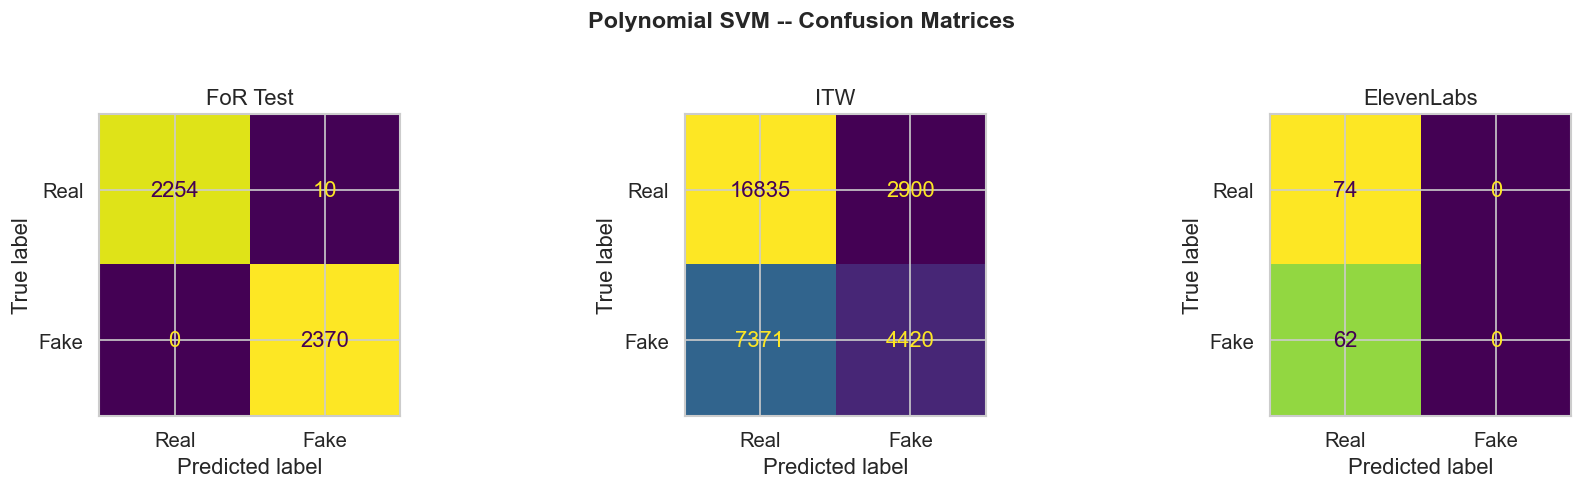

In [24]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Polynomial SVM -- Confusion Matrices")

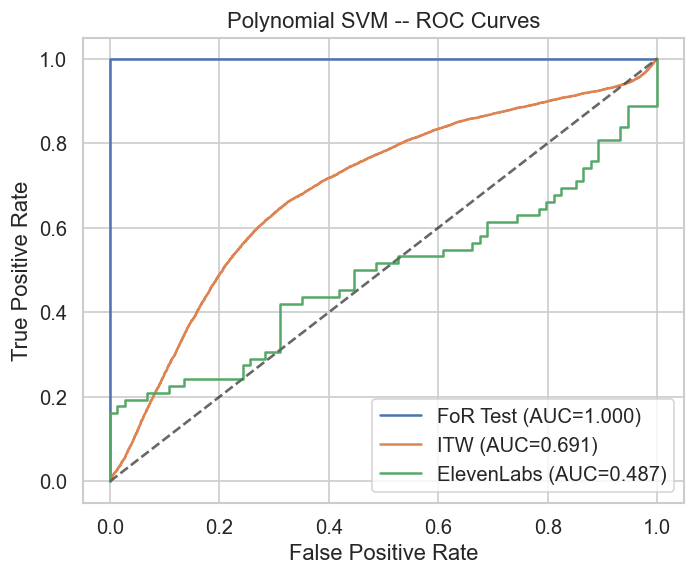

In [25]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Polynomial SVM -- ROC Curves")

### 3.5 Sigmoid SVM

In [26]:
name = "Sigmoid SVM"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  kernel: ['sigmoid']
  C: [0.01, 0.1, 1]
  gamma: ['scale', 0.01]
  coef0: [-1.0, 0.0, 1.0]

Best Parameters: {
  "svm__C": 0.1,
  "svm__coef0": -1.0,
  "svm__gamma": "scale",
  "svm__kernel": "sigmoid"
}


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.7674,0.8343,0.7622,0.7527,0.7933
ITW,0.6601,0.6768,0.6864,0.6585,0.7038
ElevenLabs,0.6397,0.6777,0.6140,0.5908,0.6122


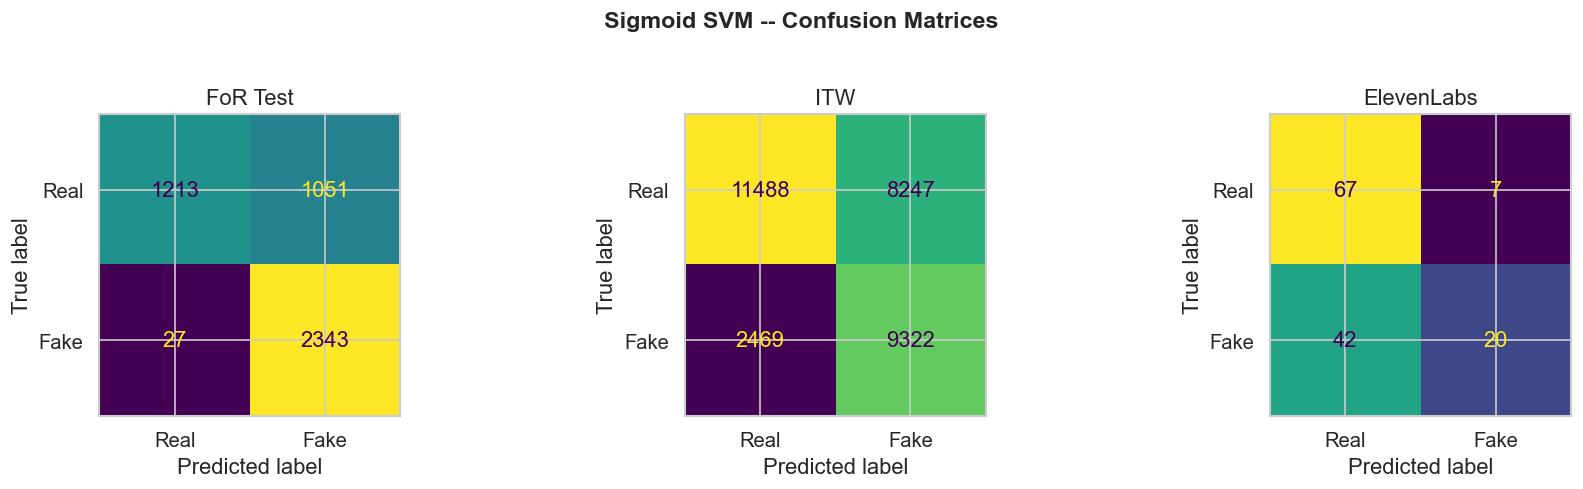

In [27]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Sigmoid SVM -- Confusion Matrices")

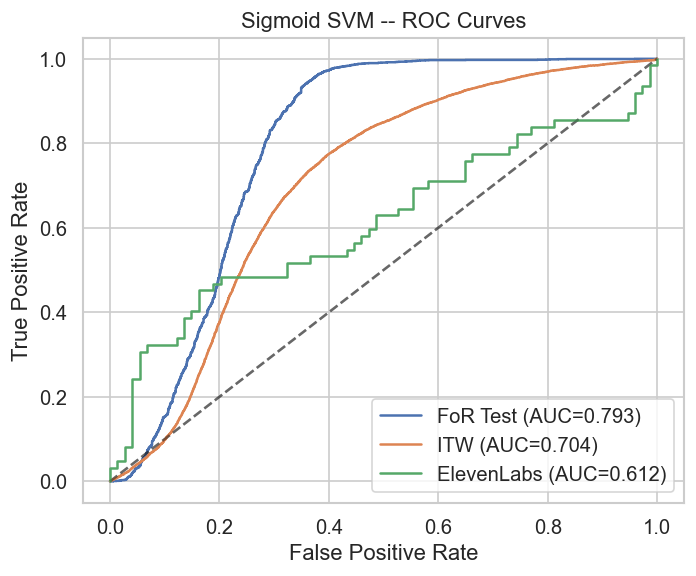

In [28]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Sigmoid SVM -- ROC Curves")

### 3.6 Decision Tree

In [29]:
name = "Decision Tree"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

# For DTree, model_params.json has the grid space; extract best params from the model itself
best_dt_params = {
    "max_depth": model.max_depth,
    "min_samples_split": model.min_samples_split,
    "min_samples_leaf": model.min_samples_leaf,
    "criterion": model.criterion,
    "class_weight": str(model.class_weight),
    "ccp_alpha": model.ccp_alpha,
}
print(f"\nBest Parameters (from trained model): {json.dumps(best_dt_params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  max_depth: range(5, 20)
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  class_weight: ['{0:1, 1:5}', None]
  criterion: ['gini', 'entropy']
  ccp_alpha: [0.0, 0.0001, 0.001, 0.01]

Best Parameters (from trained model): {
  "max_depth": 10,
  "min_samples_split": 2,
  "min_samples_leaf": 2,
  "criterion": "gini",
  "class_weight": "{0: 1, 1: 5}",
  "ccp_alpha": 0.0
}


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.9650,0.9673,0.9643,0.9649,0.9677
ITW,0.5905,0.5495,0.5451,0.5446,0.5216
ElevenLabs,0.6691,0.7857,0.6384,0.6044,0.7730


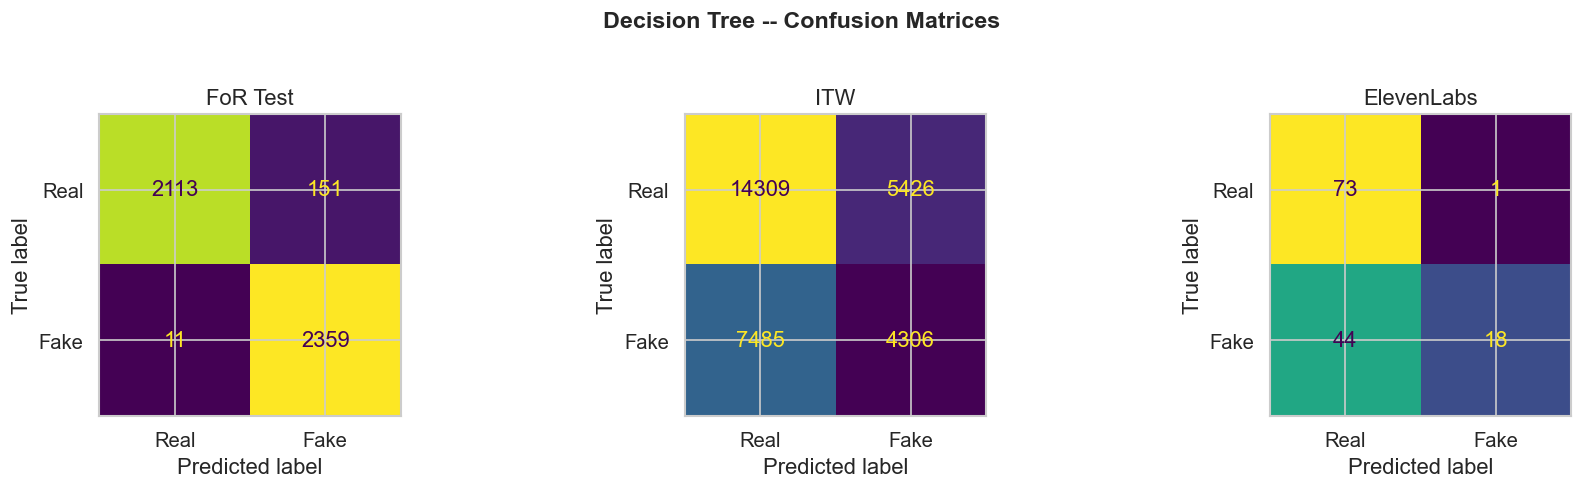

In [30]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Decision Tree -- Confusion Matrices")

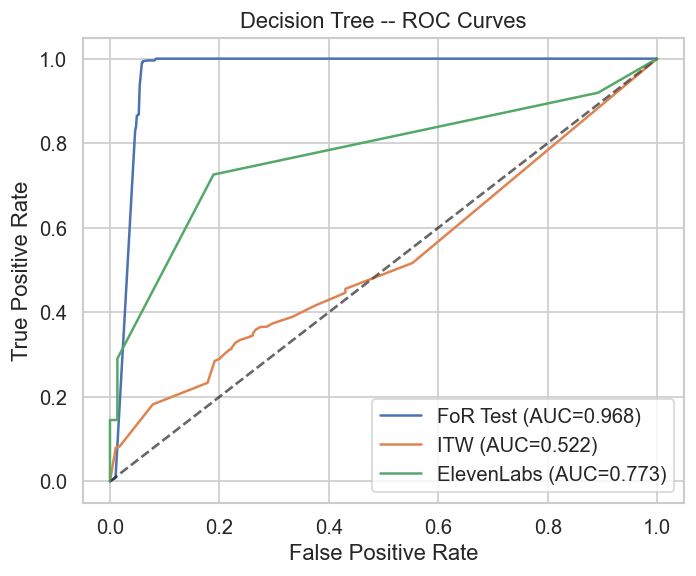

In [31]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Decision Tree -- ROC Curves")

### 3.7 Random Forest

In [ ]:
name = "Random Forest"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  n_estimators: [300, 500, 700, 800]
  max_depth: [2, 3, 4, 5]
  max_features: ['sqrt', 'log2']
  min_samples_split: [5, 10, 20]
  min_samples_leaf: [2, 5, 10]
  max_samples: [0.5, 0.6, 0.7]
  class_weight: ['{0:1, 1:5}', None]

Best Parameters: {
  "rf__class_weight": null,
  "rf__max_depth": 4,
  "rf__max_features": "sqrt",
  "rf__max_samples": 0.6,
  "rf__min_samples_leaf": 5,
  "rf__min_samples_split": 20,
  "rf__n_estimators": 500
}


c:\Users\geon9\MSc\audio-deepfake-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.8658,0.8856,0.8632,0.8634,0.9701
ITW,0.6400,0.6006,0.5655,0.5545,0.6505
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.8272


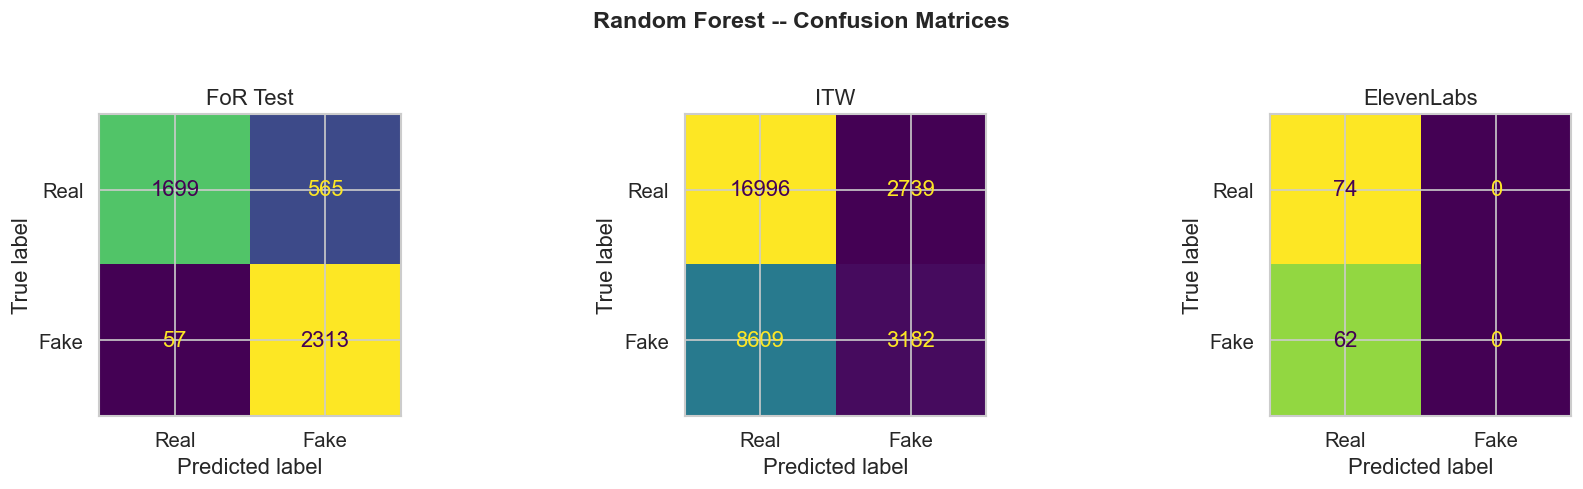

In [33]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="Random Forest -- Confusion Matrices")

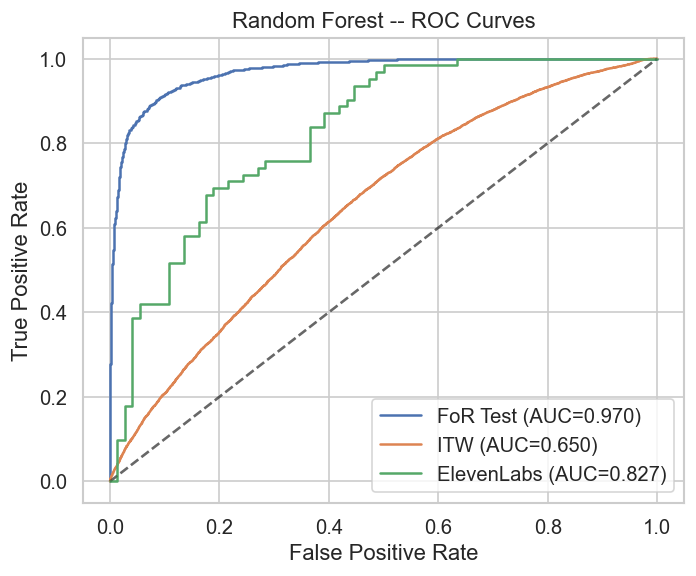

In [34]:
plot_roc_curves_overlay(model, datasets, ds_names, title="Random Forest -- ROC Curves")

### 3.8 XGBoost

In [35]:
name = "XGBoost"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

datasets = [(X_for, y_for), (X_itw, y_itw), (X_eleven, y_eleven)]
ds_names = ["FoR Test", "ITW", "ElevenLabs"]

results = {}
for (X, y), ds_name in zip(datasets, ds_names):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  max_depth: [3, 4, 2]
  learning_rate: [0.03, 0.05]
  n_estimators: [700, 800]
  min_child_weight: [10, 20]
  gamma: [0.3]
  reg_lambda: [2, 1]
  reg_alpha: [0.5]
  subsample: [0.6, 0.7, 0.5]
  colsample_bytree: [0.6, 0.7]
  scale_pos_weight: [2]

Best Parameters: {
  "xgb__colsample_bytree": 0.7,
  "xgb__gamma": 0.3,
  "xgb__learning_rate": 0.03,
  "xgb__max_depth": 2,
  "xgb__min_child_weight": 20,
  "xgb__n_estimators": 800,
  "xgb__objective": "binary:logistic",
  "xgb__reg_alpha": 0.5,
  "xgb__reg_lambda": 2,
  "xgb__scale_pos_weight": 2,
  "xgb__subsample": 0.6
}


c:\Users\geon9\MSc\audio-deepfake-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.9907,0.9910,0.9905,0.9907,0.9997
ITW,0.6653,0.6959,0.5646,0.5263,0.7282
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.6643


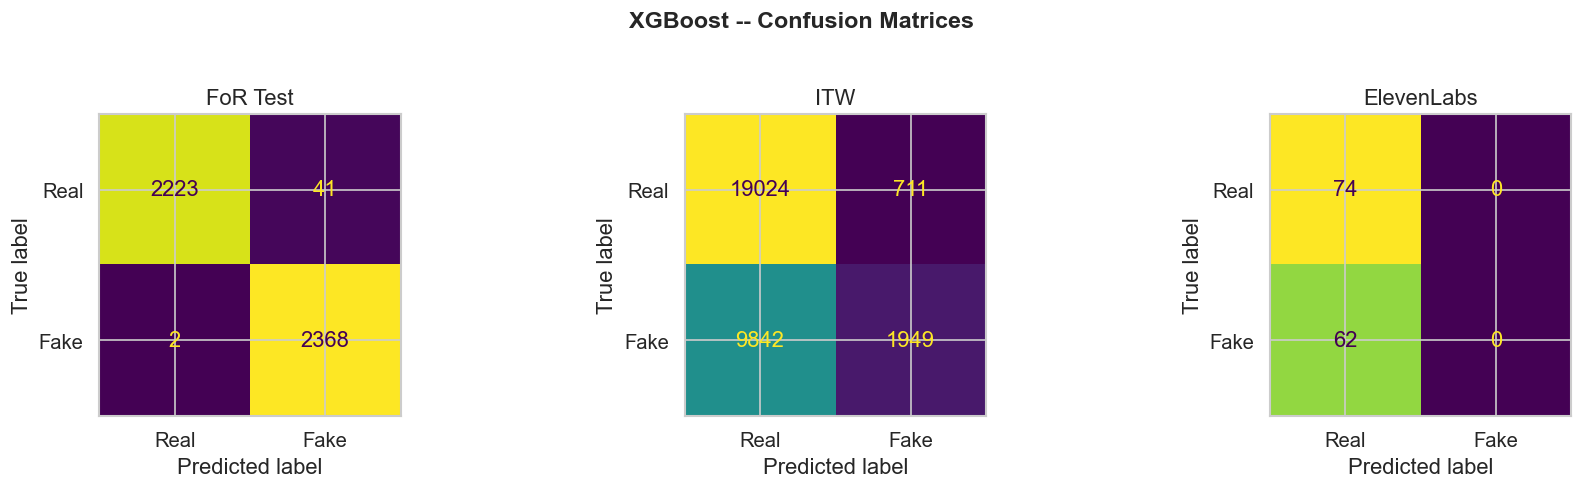

In [36]:
plot_confusion_matrices(model, datasets, ds_names, suptitle="XGBoost -- Confusion Matrices")

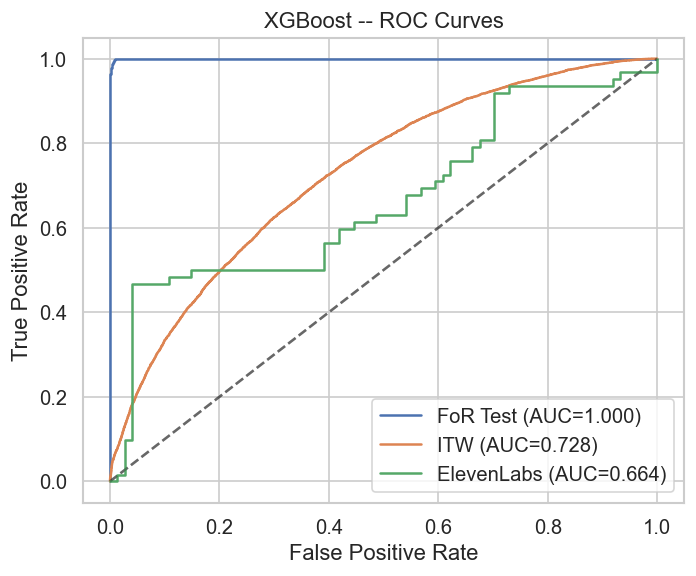

In [37]:
plot_roc_curves_overlay(model, datasets, ds_names, title="XGBoost -- ROC Curves")

### 3.9 XGBoost (no mel spectrogram features)

In [38]:
name = "XGBoost (no mel)"
model, saved_metrics, params, metadata = load_experiment(name)

print("Grid Search Space:")
for k, v in GRID_SEARCH_SPACES[name].items():
    print(f"  {k}: {v}")

print(f"\nBest Parameters: {json.dumps(params, indent=2)}")

# Use no-mel datasets
datasets_nm = []
ds_names_nm = []
if X_for_nm is not None:
    datasets_nm.append((X_for_nm, y_for_nm))
    ds_names_nm.append("FoR Test")
if X_itw_nm is not None:
    datasets_nm.append((X_itw_nm, y_itw_nm))
    ds_names_nm.append("ITW")
if X_eleven_nm is not None:
    datasets_nm.append((X_eleven_nm, y_eleven_nm))
    ds_names_nm.append("ElevenLabs")

results = {}
for (X, y), ds_name in zip(datasets_nm, ds_names_nm):
    m, _ = evaluate_on_dataset(model, X, y)
    results[ds_name] = m

results_df = pd.DataFrame(results).T
display(results_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=None))

all_results[name] = results

Grid Search Space:
  max_depth: [3, 4, 5]
  learning_rate: [0.01, 0.03, 0.05]
  n_estimators: [300, 500, 700]
  min_child_weight: [5, 10, 20]
  gamma: [0.1, 0.3, 0.5]
  reg_lambda: [2, 5, 10]
  reg_alpha: [0, 0.5, 1]
  subsample: [0.6, 0.7, 0.8]
  colsample_bytree: [0.6, 0.7, 0.8]
  scale_pos_weight: [1, 2, 3]

Best Parameters: {
  "xgb__colsample_bytree": 0.6,
  "xgb__gamma": 0.3,
  "xgb__learning_rate": 0.05,
  "xgb__max_depth": 3,
  "xgb__min_child_weight": 20,
  "xgb__n_estimators": 700,
  "xgb__reg_alpha": 0.5,
  "xgb__reg_lambda": 2,
  "xgb__scale_pos_weight": 2,
  "xgb__subsample": 0.6
}


c:\Users\geon9\MSc\audio-deepfake-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1 (macro),ROC AUC
FoR Test,0.9784,0.9797,0.9779,0.9784,0.9997
ITW,0.7415,0.7310,0.6982,0.7059,0.7857
ElevenLabs,0.5441,0.2721,0.5000,0.3524,0.6720


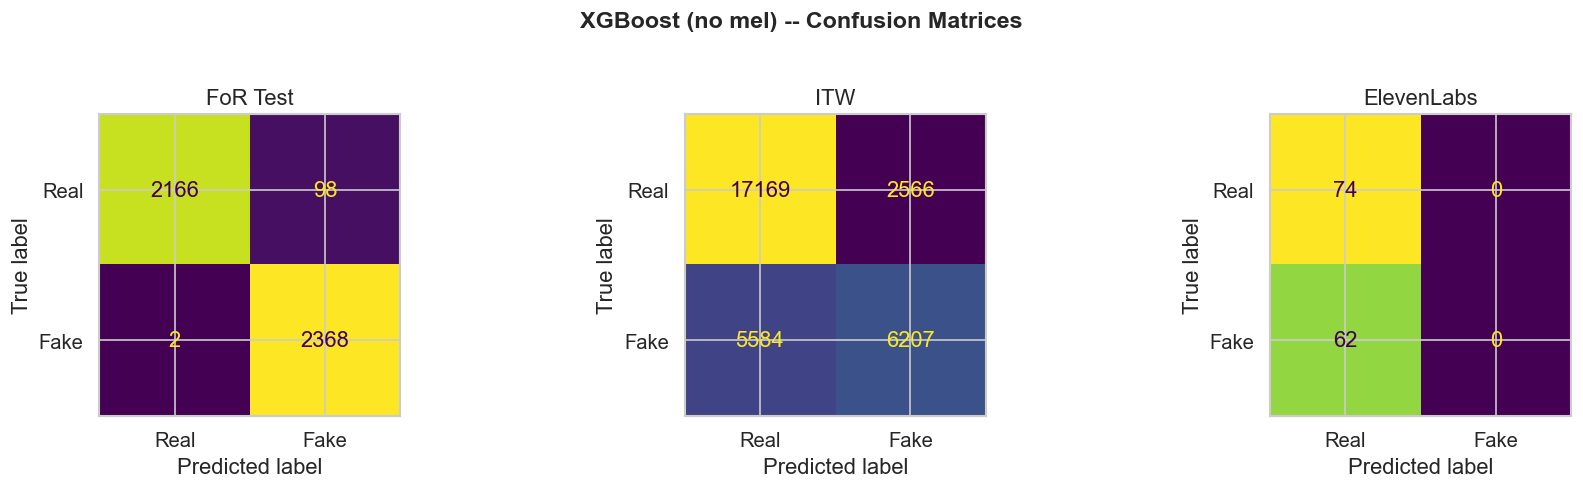

In [39]:
plot_confusion_matrices(model, datasets_nm, ds_names_nm,
                        suptitle="XGBoost (no mel) -- Confusion Matrices")

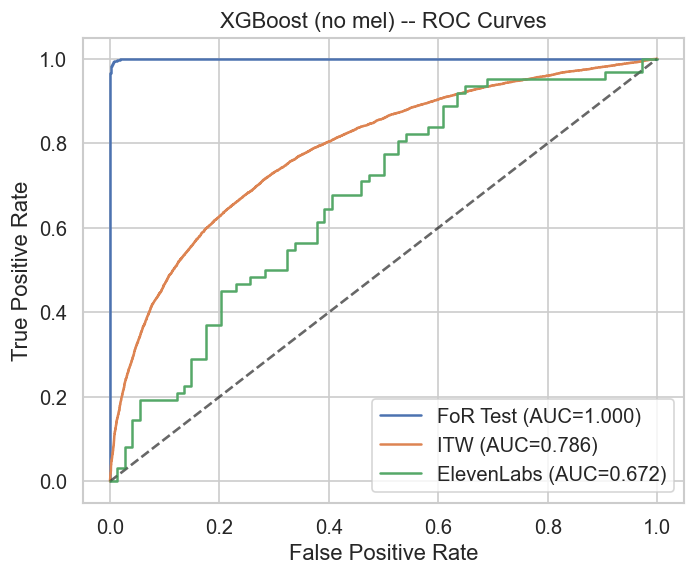

In [40]:
plot_roc_curves_overlay(model, datasets_nm, ds_names_nm,
                        title="XGBoost (no mel) -- ROC Curves")

---
## 4. Zero-Shot Evaluation Summary

This section compares all models on the In-the-Wild and ElevenLabs datasets, which the models have never seen during training (zero-shot generalization).

In [ ]:
# ── Build comparison tables ──
itw_rows = []
eleven_rows = []

for model_name, res in all_results.items():
    if "ITW" in res:
        itw_rows.append({"Model": model_name, **res["ITW"]})
    if "ElevenLabs" in res:
        eleven_rows.append({"Model": model_name, **res["ElevenLabs"]})

itw_df = pd.DataFrame(itw_rows).set_index("Model")
eleven_df = pd.DataFrame(eleven_rows).set_index("Model")

print("=" * 60)
print("Zero-Shot Results on In-the-Wild Dataset")
print("=" * 60)
display(itw_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=0))

print()
print("=" * 60)
print("Zero-Shot Results on ElevenLabs Dataset")
print("=" * 60)
display(eleven_df.style.format("{:.4f}").background_gradient(cmap="RdYlGn", axis=0))

In [ ]:
# ── Grouped bar chart: F1 scores across models and datasets ──
bar_data = []
for model_name, res in all_results.items():
    for ds_name in ["FoR Test", "ITW", "ElevenLabs"]:
        if ds_name in res:
            bar_data.append({
                "Model": model_name,
                "Dataset": ds_name,
                "F1 (macro)": res[ds_name]["F1 (macro)"]
            })

bar_df = pd.DataFrame(bar_data)

fig, ax = plt.subplots(figsize=(14, 6))
models = list(all_results.keys())
x = np.arange(len(models))
width = 0.25

for i, ds in enumerate(["FoR Test", "ITW", "ElevenLabs"]):
    vals = []
    for m in models:
        if ds in all_results[m]:
            vals.append(all_results[m][ds]["F1 (macro)"])
        else:
            vals.append(0)
    ax.bar(x + i * width, vals, width, label=ds)

ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=9)
ax.set_ylabel("F1 Score (macro)")
ax.set_title("F1 Score Comparison Across Models and Datasets", fontweight="bold")
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Zero-Shot Confusion Matrices (All Models)

In [ ]:
# ── Confusion matrices for all models on ITW ──
n_models = len(MODEL_REGISTRY)
ncols = 3
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes_flat = axes.flatten()

for idx, (model_name, (subdir, uses_no_mel)) in enumerate(MODEL_REGISTRY.items()):
    model_obj = joblib.load(os.path.join(FINAL_MODELS_PATH, subdir, "model.joblib"))
    if uses_no_mel and X_itw_nm is not None:
        X_eval, y_eval = X_itw_nm, y_itw_nm
    else:
        X_eval, y_eval = X_itw, y_itw
    y_pred = model_obj.predict(X_eval)
    cm = confusion_matrix(y_eval, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
    disp.plot(ax=axes_flat[idx], colorbar=False)
    axes_flat[idx].set_title(model_name, fontsize=10)

for j in range(idx + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

fig.suptitle("Zero-Shot Confusion Matrices -- In-the-Wild", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
# ── Confusion matrices for all models on ElevenLabs ──
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes_flat = axes.flatten()

for idx, (model_name, (subdir, uses_no_mel)) in enumerate(MODEL_REGISTRY.items()):
    model_obj = joblib.load(os.path.join(FINAL_MODELS_PATH, subdir, "model.joblib"))
    if uses_no_mel and X_eleven_nm is not None:
        X_eval, y_eval = X_eleven_nm, y_eleven_nm
    else:
        X_eval, y_eval = X_eleven, y_eleven
    y_pred = model_obj.predict(X_eval)
    cm = confusion_matrix(y_eval, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
    disp.plot(ax=axes_flat[idx], colorbar=False)
    axes_flat[idx].set_title(model_name, fontsize=10)

for j in range(idx + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

fig.suptitle("Zero-Shot Confusion Matrices -- ElevenLabs", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

---
## 5. Conclusion

### Key Findings

**Best Performing Models:**
- On the FoR test set, models trained and validated within the same distribution (Logistic Regression, Linear SVM) show strong and stable metrics around ~0.71 accuracy and ~0.78 ROC AUC.
- The XGBoost (no mel) variant achieves the strongest FoR test set performance overall (0.74 accuracy, 0.71 F1, 0.79 ROC AUC), suggesting that mel spectrogram features may introduce noise for gradient-boosted models.
- Tree-based models (Decision Tree, Random Forest) show high validation scores but weaker generalization to the test set, indicating overfitting to FoR distribution characteristics.

**Impact of Mel Spectrogram Features:**
- Comparing XGBoost (195 features, with mel) vs. XGBoost no-mel (67 features, without mel), removing mel spectrogram features improved test performance notably (F1: 0.53 -> 0.71), demonstrating that mel features can harm generalization for some model types.
- This finding is consistent with the feature importance analysis, where MFCC, delta, and spectral features dominate the logistic regression coefficients.

**Zero-Shot Generalization:**
- All models experience a performance gap when moving from the FoR test set to the In-the-Wild and ElevenLabs datasets, which is expected given the domain shift between controlled and in-the-wild recordings.
- Linear models (Logistic Regression, Linear SVM) tend to generalize more consistently across domains compared to non-linear models, likely due to their simpler decision boundaries being less susceptible to dataset-specific artifacts.

**Feature Selection Insights:**
- By comparing logistic regression scores across different feature subsets, we found that dropping standard deviation features and keeping only mean aggregations improved performance from F1=0.72 to F1=0.78 on the FoR validation set.
- Mel spectrogram features proved essential -- removing them caused performance to collapse (F1=0.55), despite the high internal correlation visible in the heatmaps.
- The correlation heatmaps show strong redundancy within mel spectrogram bands, which may explain why tree-based models overfit when mel features are included.
